# McDonald's reviews sentiment analyis

The goal of this project is to apply natural language processing techniques on review texts and choose the best machine learning classification algorithm to predict the sentiment of them.

Source: [kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews](https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews)

## Import packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier

from cleaning import *
from evaluation import *
from visualization import *

import time
start_time = time.time()

## Load dataset

In [2]:
df = pd.read_csv('data/mcdonalds.csv', encoding='latin-1')

In [3]:
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [4]:
df.shape

(33396, 10)

In [5]:
df.dtypes

reviewer_id        int64
store_name        object
category          object
store_address     object
latitude         float64
longitude        float64
rating_count      object
review_time       object
review            object
rating            object
dtype: object

Checking duplicated rows:

In [6]:
len(df.loc[df.duplicated()])

0

Checking whitespaces and missing values:

In [7]:
for col in df.select_dtypes(include='object').columns.tolist():

        if df.loc[df[col].apply(lambda x: x.isspace())].empty == False:
                print(f'{col} has {len(df.loc[df[col].apply(lambda x: x.isspace())])} rows with only space characters. It will be replaced by NaN.')
                df.loc[df[col].apply(lambda x: x.isspace()), col] = np.nan
                df[col] = df[col].astype(float)

In [8]:
df.isnull().sum()

reviewer_id        0
store_name         0
category           0
store_address      0
latitude         660
longitude        660
rating_count       0
review_time        0
review             0
rating             0
dtype: int64

Drop unnecessary columns:

In [9]:
df.drop(['store_name', 'category', 'latitude ', 'longitude', 'rating_count'], axis=1, inplace=True)

## Feature engineering

Get the city name of the store address:

In [10]:
for item in df['store_address'].unique().tolist():
    if item.count(',') != 3:
        print(item, item.count(','))

By Mandalay Bay, 3999 S Las Vegas Blvd, Las Vegas, NV 89119, United States 4
2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ 0


In [11]:
df['store_city'] = df['store_address'].apply(lambda x: x.split(',')[-3].strip() if x.count(',') != 0 else np.nan)

Create a new feature as **review time in years**, where reviews written in less than 1 year are labeled as 0:

In [12]:
df['review_time_in_years'] = df['review_time'].copy()
df['review_time_in_years'].replace({'a year ago': '1 year ago'}, inplace=True)
df['review_time_in_years'] = df['review_time_in_years'].apply(lambda x: int(x.split(' ')[0]) if 'year' in x else 0)

Create the **target sentiment feature** from review stars. Negative review means the star is equal or less than 3, otherwise it is positive.

In [13]:
df['review_star'] = df['rating'].apply(lambda x: int(x[0]))
df['star_class'] = df['review_star'].apply(lambda x: "negative" if x <= 3 else "positive")

Drop unnecessary columns:

In [14]:
df.drop(['store_address', 'review_time', 'rating'], axis=1, inplace=True)

Apply a cleaning script for the text reviews:

* Replace apostrophes in especially negation of modal verbs like **wont -> won't** then **won't -> will not** and short forms like **'ve -> have** or **'ll -> will**
* Keep only letters and numbers
* A default list of stopwords from **nltk** library used for further text analysis. Some words like **[no, not, very]** were removed, but words like **[mcdonalds, service, food]** were added to this list. To get an essential part of each review, these stopwords were removed from texts.

In [15]:
df['clean_review'] = df['review'].apply(lambda x: clean_text(x, include_stopwords=False))

## Exploratory Data Analysis

Create barplots for categorical features like **review star** and **review time**:

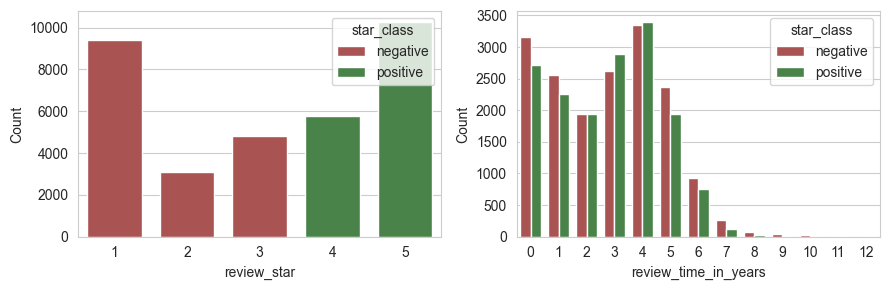

In [16]:
plot_categories(df, ['review_star', 'review_time_in_years'], 'star_class')

* Sum of positive (4 or 5 stars) and negative (1, 2 or 3 stars) reviews are in balance.
* The most recent reviews of the last 24 months are more likely to be negative as well as reviews older than 5 years.

The top ten most frequented cities can be seen below:

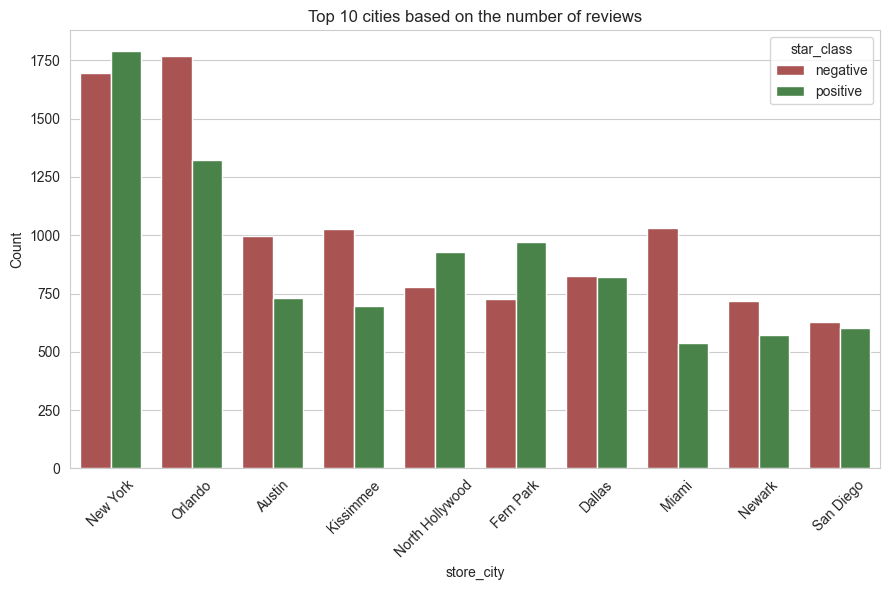

In [17]:
plot_top_n_cities(df, 'store_city', 'star_class', n=10)

The top ten most positive cities can be seen below:

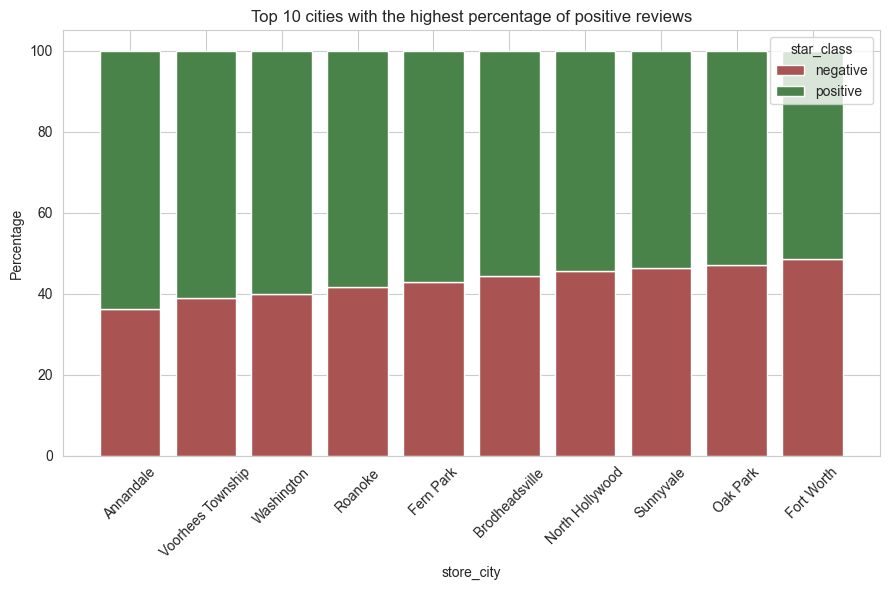

In [18]:
plot_top_n_cities_by_pct_target(df, 'store_city', 'star_class', target_value='positive', n=10)

The top ten most negative cities can be seen below:

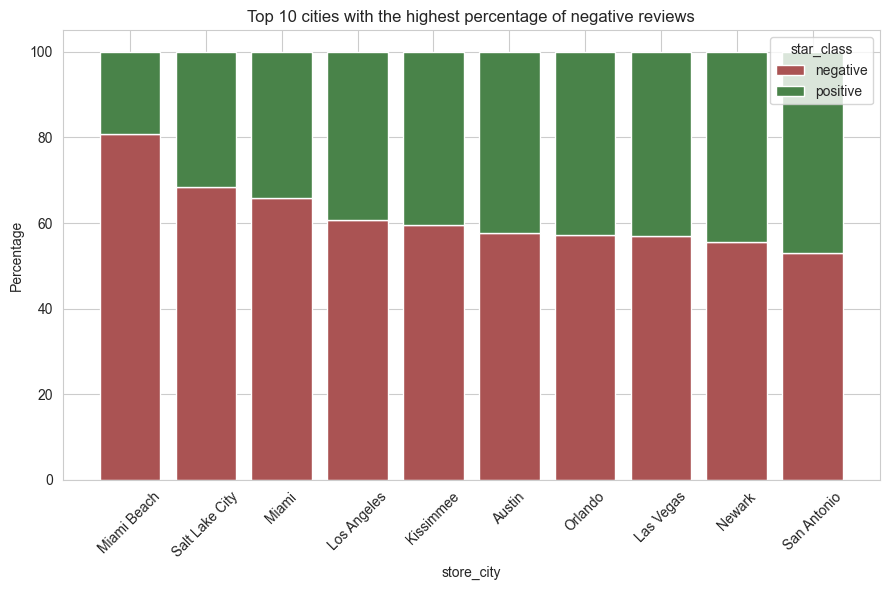

In [19]:
plot_top_n_cities_by_pct_target(df, 'store_city', 'star_class', target_value='negative', n=10)

- **Word cloud** of positive reviews based on the clean texts:

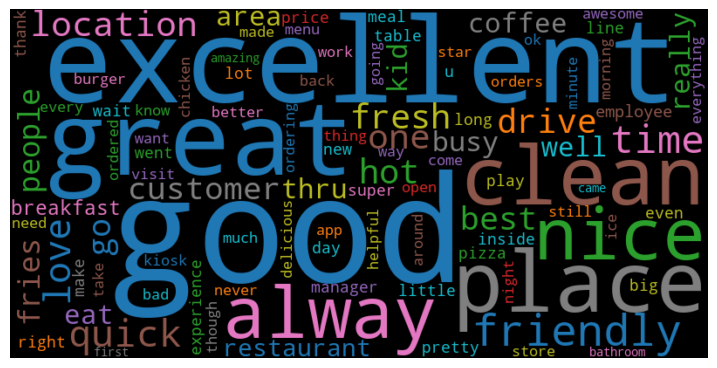

In [20]:
wordcloud_by_class(df, 'clean_review', 'star_class', 'positive')

Some words like *excellent, great, good, quick, friendly* or *clean* can be a good sign of a positive feedback.

- **Word cloud** of negative reviews based on the clean texts:

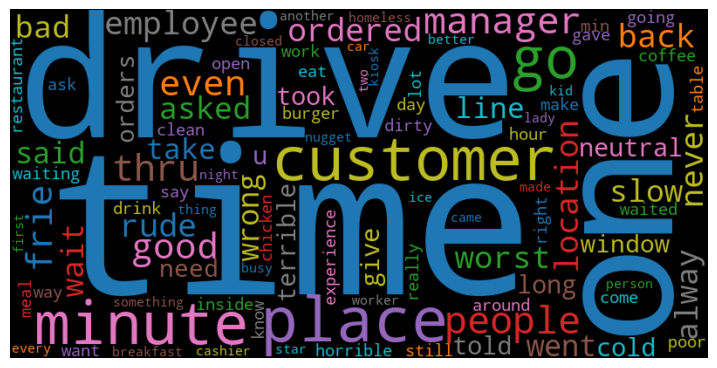

In [21]:
wordcloud_by_class(df, 'clean_review', 'star_class', 'negative')

Some words like *bad, rude, dirty, wrong* or *terrible* can be a good sign of a negative feedback.

# Classification models

**Term Frequency Inverse Document Frequency** will be applied to the only predictor as **clean review**.</br>
That transformation can show the frequency of words to determine how relevant they are to a given document. 

In [22]:
X = df['clean_review'].copy()
y = df['star_class'].copy()

Since the dataset is balanced based on the target feature the models will be evaluated by **Accuracy score**.<br/>
The same cross validation (k=5) will be used for all models to find the best probability threshold.<br/>
The goal is to maximize the Accuracy score value in each iteration then the optimal threshold will be the average of the 5 values of train samples.

In [23]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)

### Train-test splitting

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

print(f'Number of observations in train sample: {X_train.shape[0]}')
print(f'Negative reviews in train sample: {round(y_train.value_counts(normalize=True)["negative"] * 100, 2)}%')
print(f'Positive reviews in train sample: {round(y_train.value_counts(normalize=True)["positive"] * 100, 2)}%')
print('\n')
print(f'Number of observations in test sample: {X_test.shape[0]}')
print(f'Negative reviews in test sample: {round(y_test.value_counts(normalize=True)["negative"] * 100, 2)}%')
print(f'Positive reviews in test sample: {round(y_test.value_counts(normalize=True)["positive"] * 100, 2)}%')


Number of observations in train sample: 25047
Negative reviews in train sample: 51.91%
Positive reviews in train sample: 48.09%


Number of observations in test sample: 8349
Negative reviews in test sample: 51.91%
Positive reviews in test sample: 48.09%


### Vader's polarity score

In [25]:
class VadersPolarityScore(BaseEstimator, TransformerMixin):

    def __init__(self, sid=SentimentIntensityAnalyzer()):

        self.sid = sid
    
    def predict_proba(self, X):
        
        X_tmp = X.copy()
        
        return X_tmp.apply(lambda x: self.sid.polarity_scores(x)['compound'])
    
polarity = VadersPolarityScore()

In [26]:
find_threshold_cv(model=polarity, X=X_train, y=y_train.map({"negative": 0, "positive": 1}), cv=cv, vaders_polarity=True).mean()

Threshold            0.31000
Area Under Curve     0.85410
Accuracy             0.80832
Precision            0.81486
Recall               0.78562
F1-score             0.79994
Weighted F1-score    0.80816
dtype: float64

In [27]:
test_threshold(polarity, X_train, y_train.map({"negative": 0, "positive": 1}), 0.31, vaders_polarity=True)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.8545,0.8073,0.8086,0.7851,0.7967,0.8071


In [28]:
test_threshold(polarity, X_test, y_test.map({"negative": 0, "positive": 1}), 0.31, vaders_polarity=True)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.8611,0.8132,0.8135,0.7933,0.8033,0.813


Without building models a 81.32% accuracy score can be achieved on the test sample using the polarity score by Vader with a 0.31 threshold.

### Logistic regression

In [29]:
logreg = Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', LogisticRegression()),
])

logreg.fit(X_train, y_train.map({"negative": 0, "positive": 1}));

Calculate optimal probability threshold:

In [30]:
find_threshold_cv(logreg, X_train, y_train.map({"negative": 0, "positive": 1}), cv).mean()

Threshold            0.50000
Area Under Curve     0.95852
Accuracy             0.89996
Precision            0.90198
Recall               0.89188
F1-score             0.89686
Weighted F1-score    0.89996
dtype: float64

Performance on train and test sample:

In [31]:
test_threshold(logreg, X_train, y_train.map({"negative": 0, "positive": 1}), 0.50)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.9607,0.9038,0.9049,0.894,0.8994,0.9038


In [32]:
test_threshold(logreg, X_test, y_test.map({"negative": 0, "positive": 1}), 0.50)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.9496,0.8802,0.8843,0.864,0.874,0.8802


### Naive Bayes

In [33]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', MultinomialNB()),
])

nb.fit(X_train, y_train.map({"negative": 0, "positive": 1}));  

Calculate optimal probability threshold:

In [34]:
find_threshold_cv(nb, X_train, y_train.map({"negative": 0, "positive": 1}), cv).mean()

Threshold            0.46400
Area Under Curve     0.95338
Accuracy             0.88224
Precision            0.88436
Recall               0.87266
F1-score             0.87842
Weighted F1-score    0.88222
dtype: float64

Performance on train and test sample:

In [35]:
test_threshold(nb, X_train, y_train.map({"negative": 0, "positive": 1}), 0.464)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.9556,0.8865,0.8898,0.872,0.8808,0.8864


In [36]:
test_threshold(nb, X_test, y_test.map({"negative": 0, "positive": 1}), 0.464)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.9459,0.8723,0.8823,0.8476,0.8646,0.8722


### Support Vector Machine

In [37]:
svm = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', SVC(C=0.5, probability=True, random_state=0)),
])

svm.fit(X_train, y_train.map({"negative": 0, "positive": 1}));  

Calculate optimal probability threshold:

In [38]:
find_threshold_cv(svm, X_train, y_train.map({"negative": 0, "positive": 1}), cv).mean()

Threshold            0.45000
Area Under Curve     0.97226
Accuracy             0.93540
Precision            0.92696
Recall               0.94184
F1-score             0.93428
Weighted F1-score    0.93542
dtype: float64

Performance on train and test sample:

In [39]:
test_threshold(svm, X_train, y_train.map({"negative": 0, "positive": 1}), 0.45)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.9744,0.9388,0.9305,0.9432,0.9368,0.9388


In [40]:
test_threshold(svm, X_test, y_test.map({"negative": 0, "positive": 1}), 0.45)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.9494,0.8917,0.8863,0.8889,0.8876,0.8917


### LightGBM

In [41]:
lgb = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', LGBMClassifier(verbose=-1)),
])

lgb.fit(X_train, y_train.map({"negative": 0, "positive": 1}));  

Calculate optimal probability threshold:

In [42]:
find_threshold_cv(lgb, X_train, y_train.map({"negative": 0, "positive": 1}), cv).mean()

Threshold            0.51200
Area Under Curve     0.95786
Accuracy             0.88714
Precision            0.87572
Recall               0.89568
F1-score             0.88554
Weighted F1-score    0.88712
dtype: float64

Performance on train and test sample:

In [43]:
test_threshold(lgb, X_train, y_train.map({"negative": 0, "positive": 1}), 0.512)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.9609,0.893,0.8804,0.8997,0.89,0.893


In [44]:
test_threshold(lgb, X_test, y_test.map({"negative": 0, "positive": 1}), 0.512)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.9473,0.8702,0.8609,0.8707,0.8658,0.8702


## Summary

In [45]:
models_dict = {'Logistic Regression': [logreg, X_test, 0.50],
               'Naive Bayes': [nb, X_test, 0.464],
               'Support Vector Machine': [svm, X_test, 0.45],
               'LightGBM': [lgb, X_test, 0.512]}

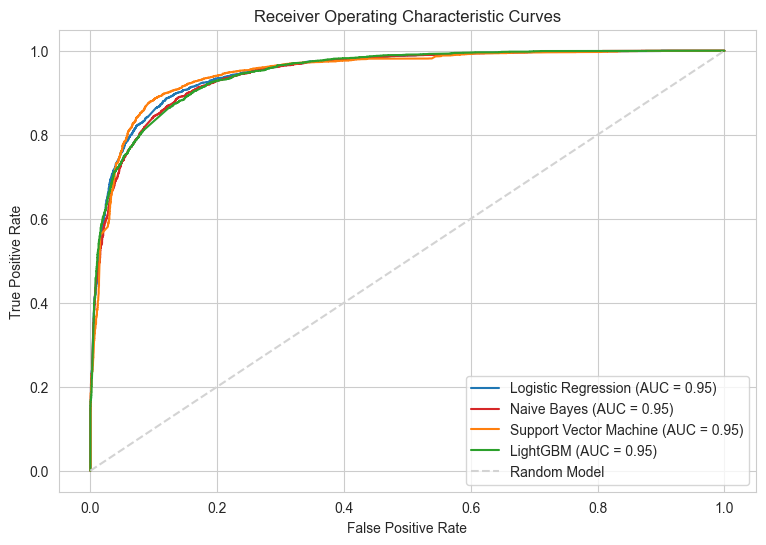

In [46]:
plot_roc_curve(models_dict, y_test.map({"negative": 0, "positive": 1}))

In [47]:
summary = pd.DataFrame()
for model_name, model_details in models_dict.items():
    summary = pd.concat([summary, test_threshold(model_details[0], model_details[1], y_test.map({"negative": 0, "positive": 1}),
                                                 model_details[2]).rename(index={0: model_name})])
summary.sort_values(by='Accuracy', ascending=False)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
Support Vector Machine,0.9494,0.8917,0.8863,0.8889,0.8876,0.8917
Logistic Regression,0.9496,0.8802,0.8843,0.8640,0.8740,0.8802
Naive Bayes,0.9459,0.8723,0.8823,0.8476,0.8646,0.8722
LightGBM,0.9473,0.8702,0.8609,0.8707,0.8658,0.8702


Based on the Accuracy score evaluation metric the **SVM** model is the best classification model for predicting the sentiment of McDonald's reviews.

Notebook running time:

In [48]:
print(f'{round((time.time() - start_time)/60,4)} minutes.')

5.9424 minutes.
